<!---<div style="text-align: center;">
    <img src="https://assets.weforum.org/article/image/large_EUoRRpPtojzeq-F-i3F0ZOrHSwoJemji8dqiTUxlnHQ.jpg" style="max-width: 700px; width:100%;" />
</div> --->

 <div style="text-align: center;">
    <img src="https://valenciaextra.com/wp-content/uploads/2020/03/fotonoticia_20200311085717_1920-7-680x365_c.jpg" style="max-width: 900px; width:100%;" />
</div>

# COVID19 dashboard

by [Héctor Ramírez](https://www.linkedin.com/in/harr/)

---

## World data

We use live COVID19 data from the [GitHub data repository](https://github.com/CSSEGISandData/COVID-19) for the 2019 Novel Coronavirus Visual Dashboard by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
custom_style = {
            'grid.color': '0.8',
            'grid.linestyle': '--',
            'grid.linewidth': 0.5,
}
sns.set_style(custom_style)
warnings.filterwarnings('ignore')

In [2]:
WORLD_CONFIRMED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
WORLD_DEATHS_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
WORLD_RECOVERED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

world_confirmed = pd.read_csv(WORLD_CONFIRMED_URL)
world_deaths = pd.read_csv(WORLD_DEATHS_URL)
world_recovered = pd.read_csv(WORLD_RECOVERED_URL)

sets = [world_confirmed, world_deaths, world_recovered]

# yesterday's date
yesterday = world_confirmed.columns[-1]
yesterday_date = str(pd.to_datetime(yesterday).date())
print('\nAccording to the latest imput, the data was updated on ' + yesterday_date + '.')


According to the latest imput, the data was updated on 2020-04-08.


---
### Cleaning the Data

The following code replaces the column name _Country/Region_ with just _Country_ and _Province/State_ with _State_. The _Province/State_ column had a bunch of NaN values which we will replace with blanks. 

In [3]:
for i in range(3):
    sets[i].rename(columns={'Country/Region':'Country', 'Province/State':'State'}, inplace=True)
    sets[i][['State']] = sets[i][['State']].fillna('')
    sets[i].fillna(0, inplace=True)

We then group by countries and sum the values.

In [4]:
sets_grouped = []
cases = ['confirmed cases', 'deaths', 'recovered cases']
for i in range(3):
    sets_grouped.append(sets[i].groupby('Country').sum())
    # print('\nTop countries by {}:\n'.format(cases[i]))
    # print(sets_grouped[i][yesterday].sort_values(ascending=False).head(5))

---
## Top countries by: confirmed cases, deaths and recoveries:

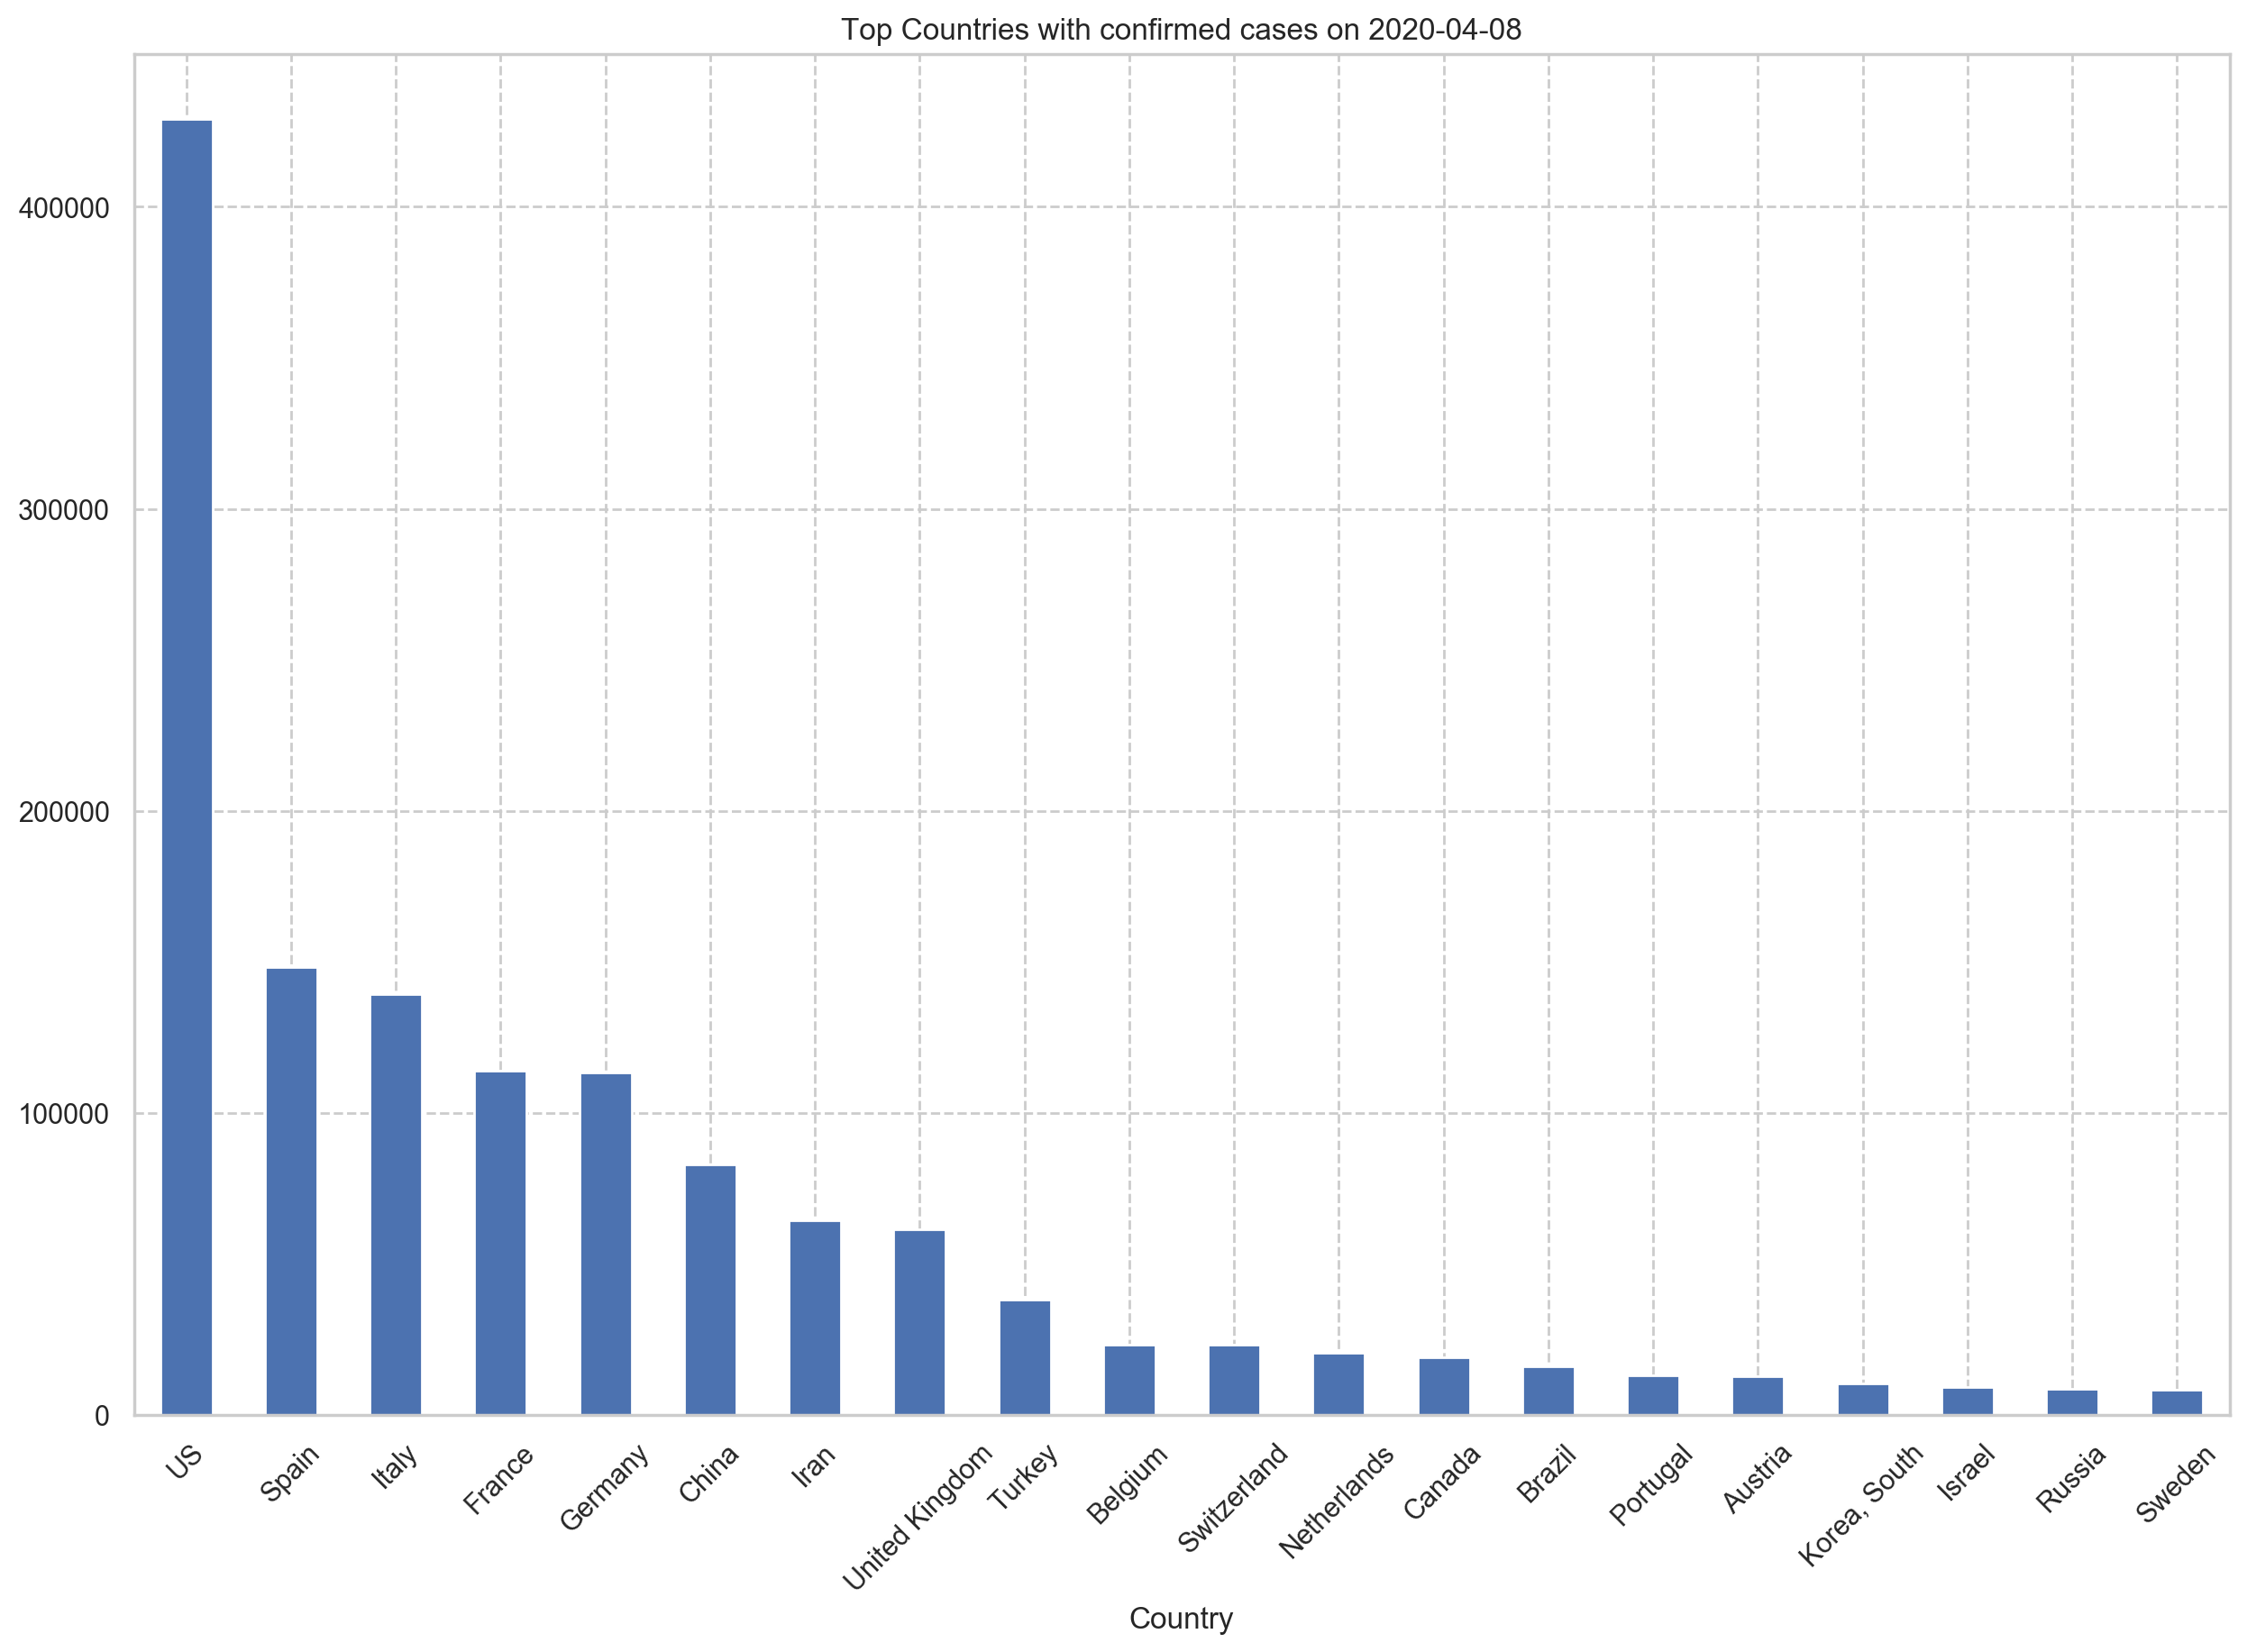

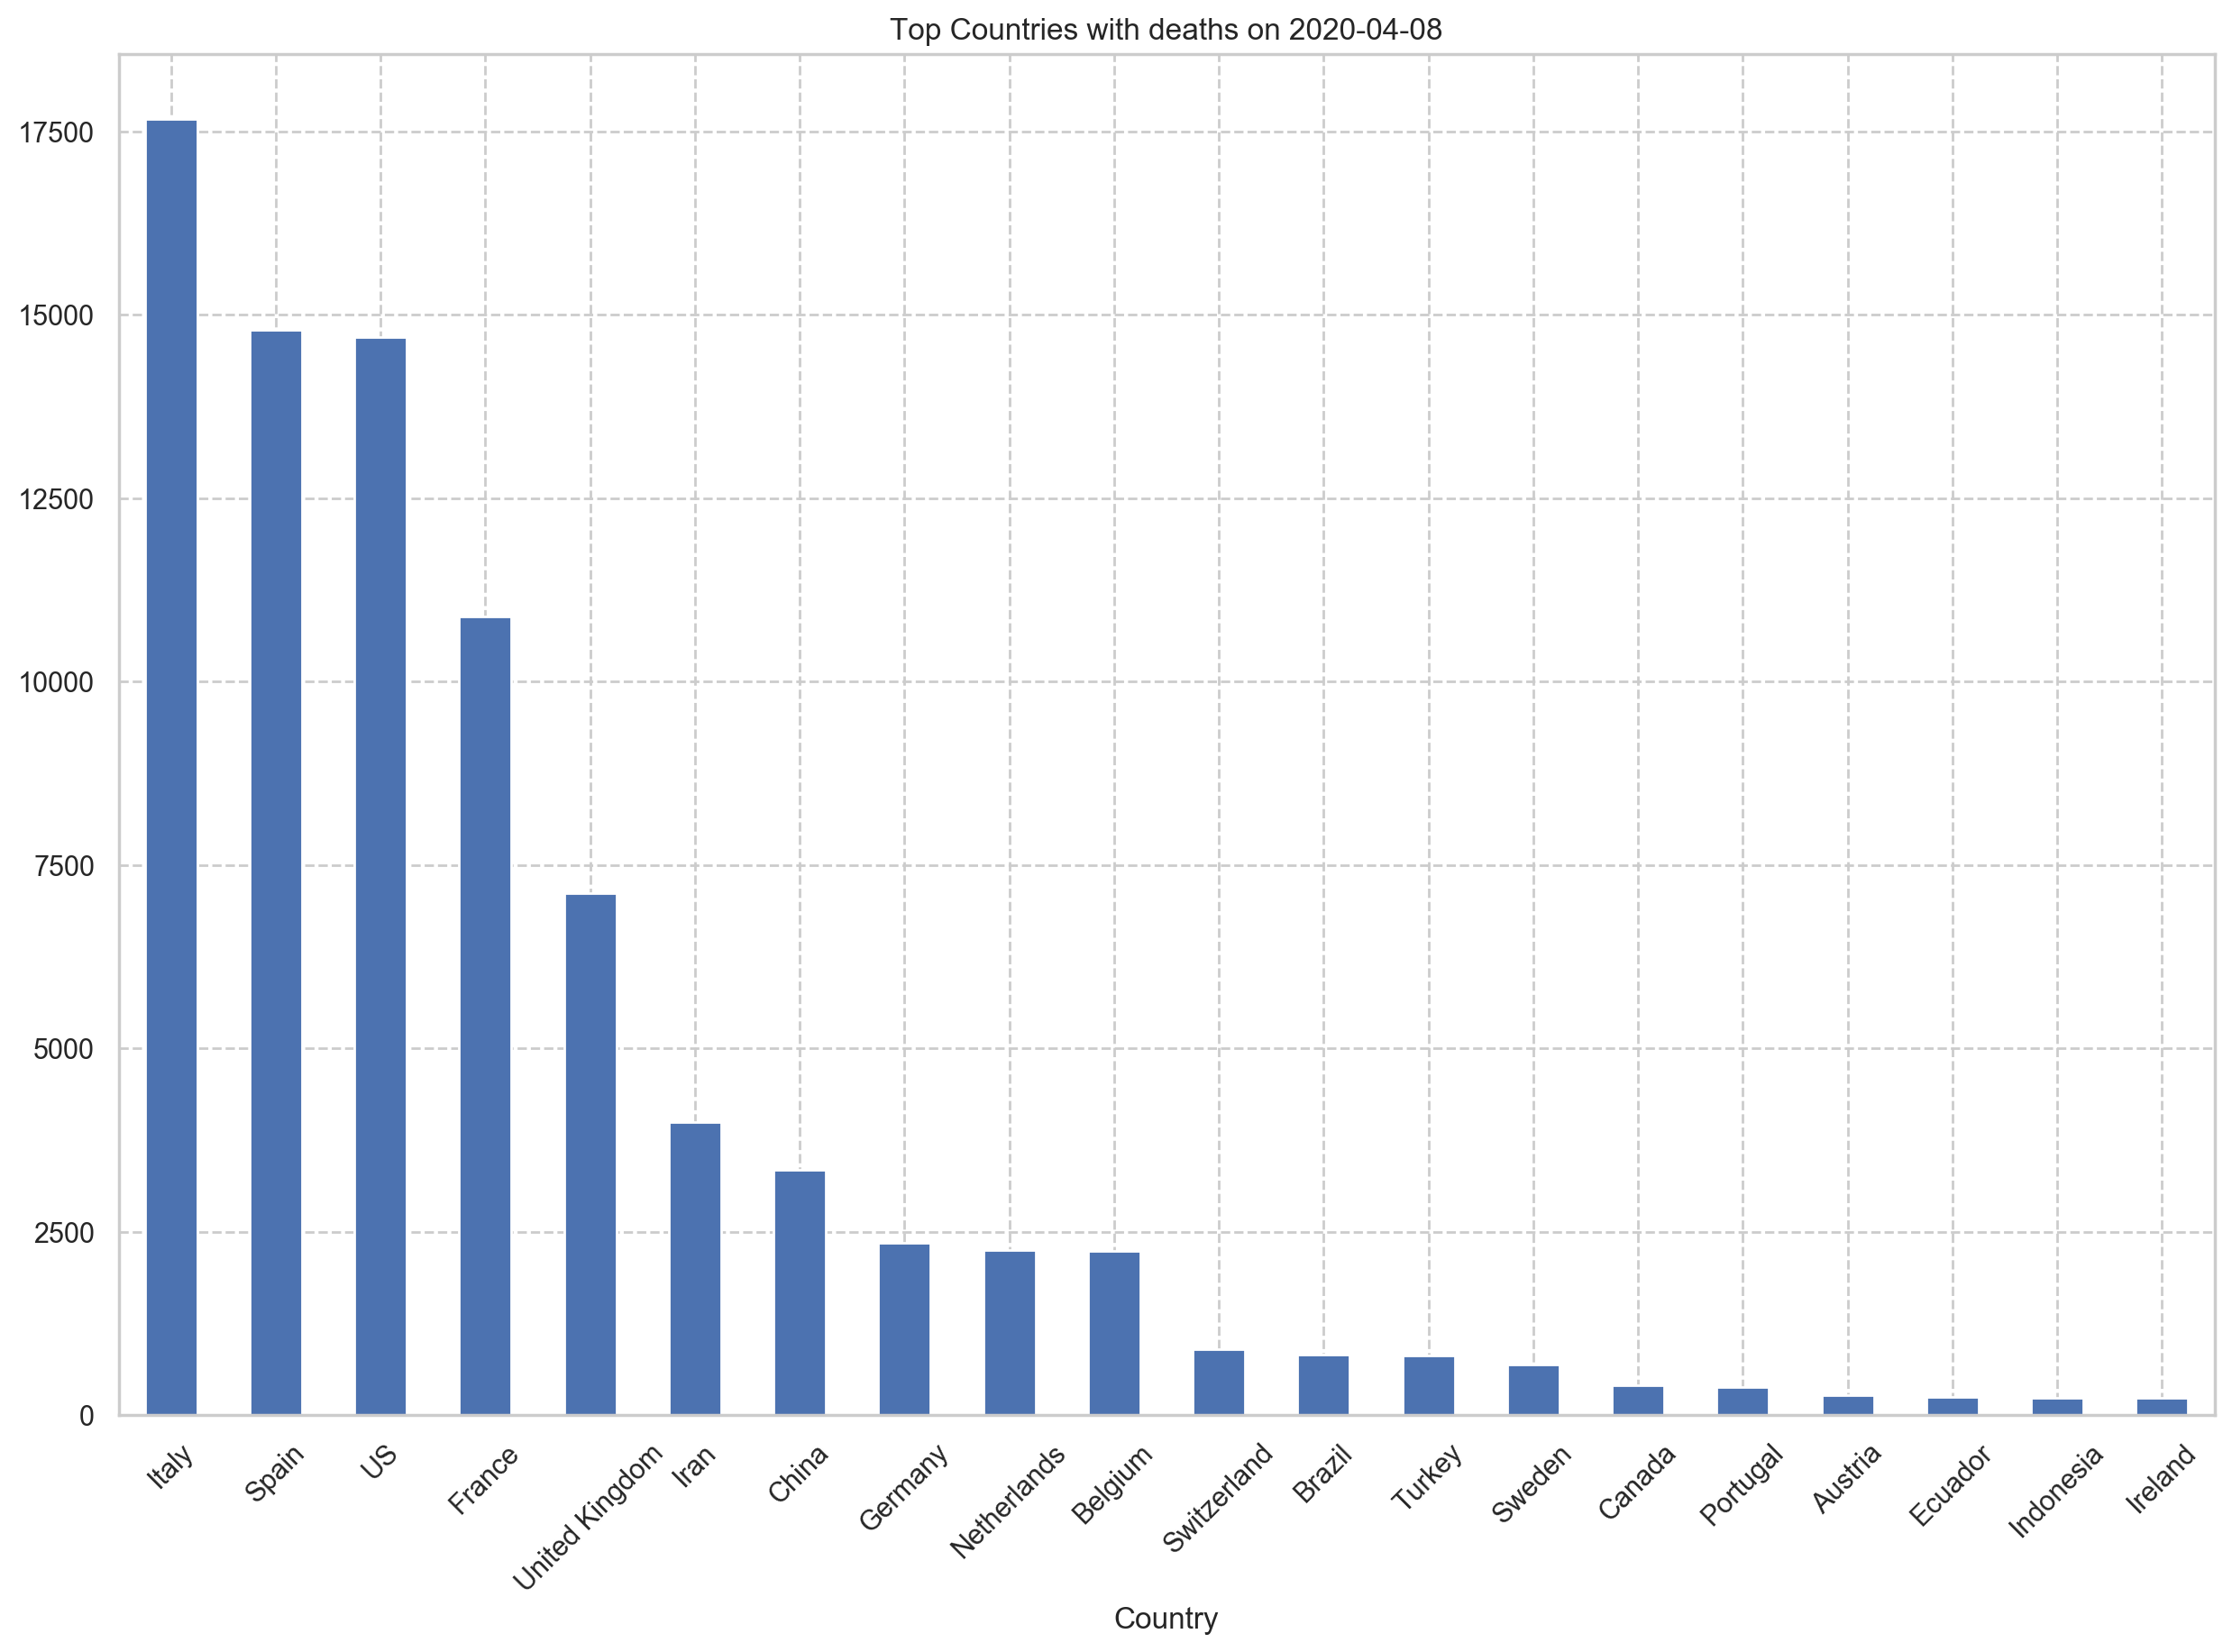

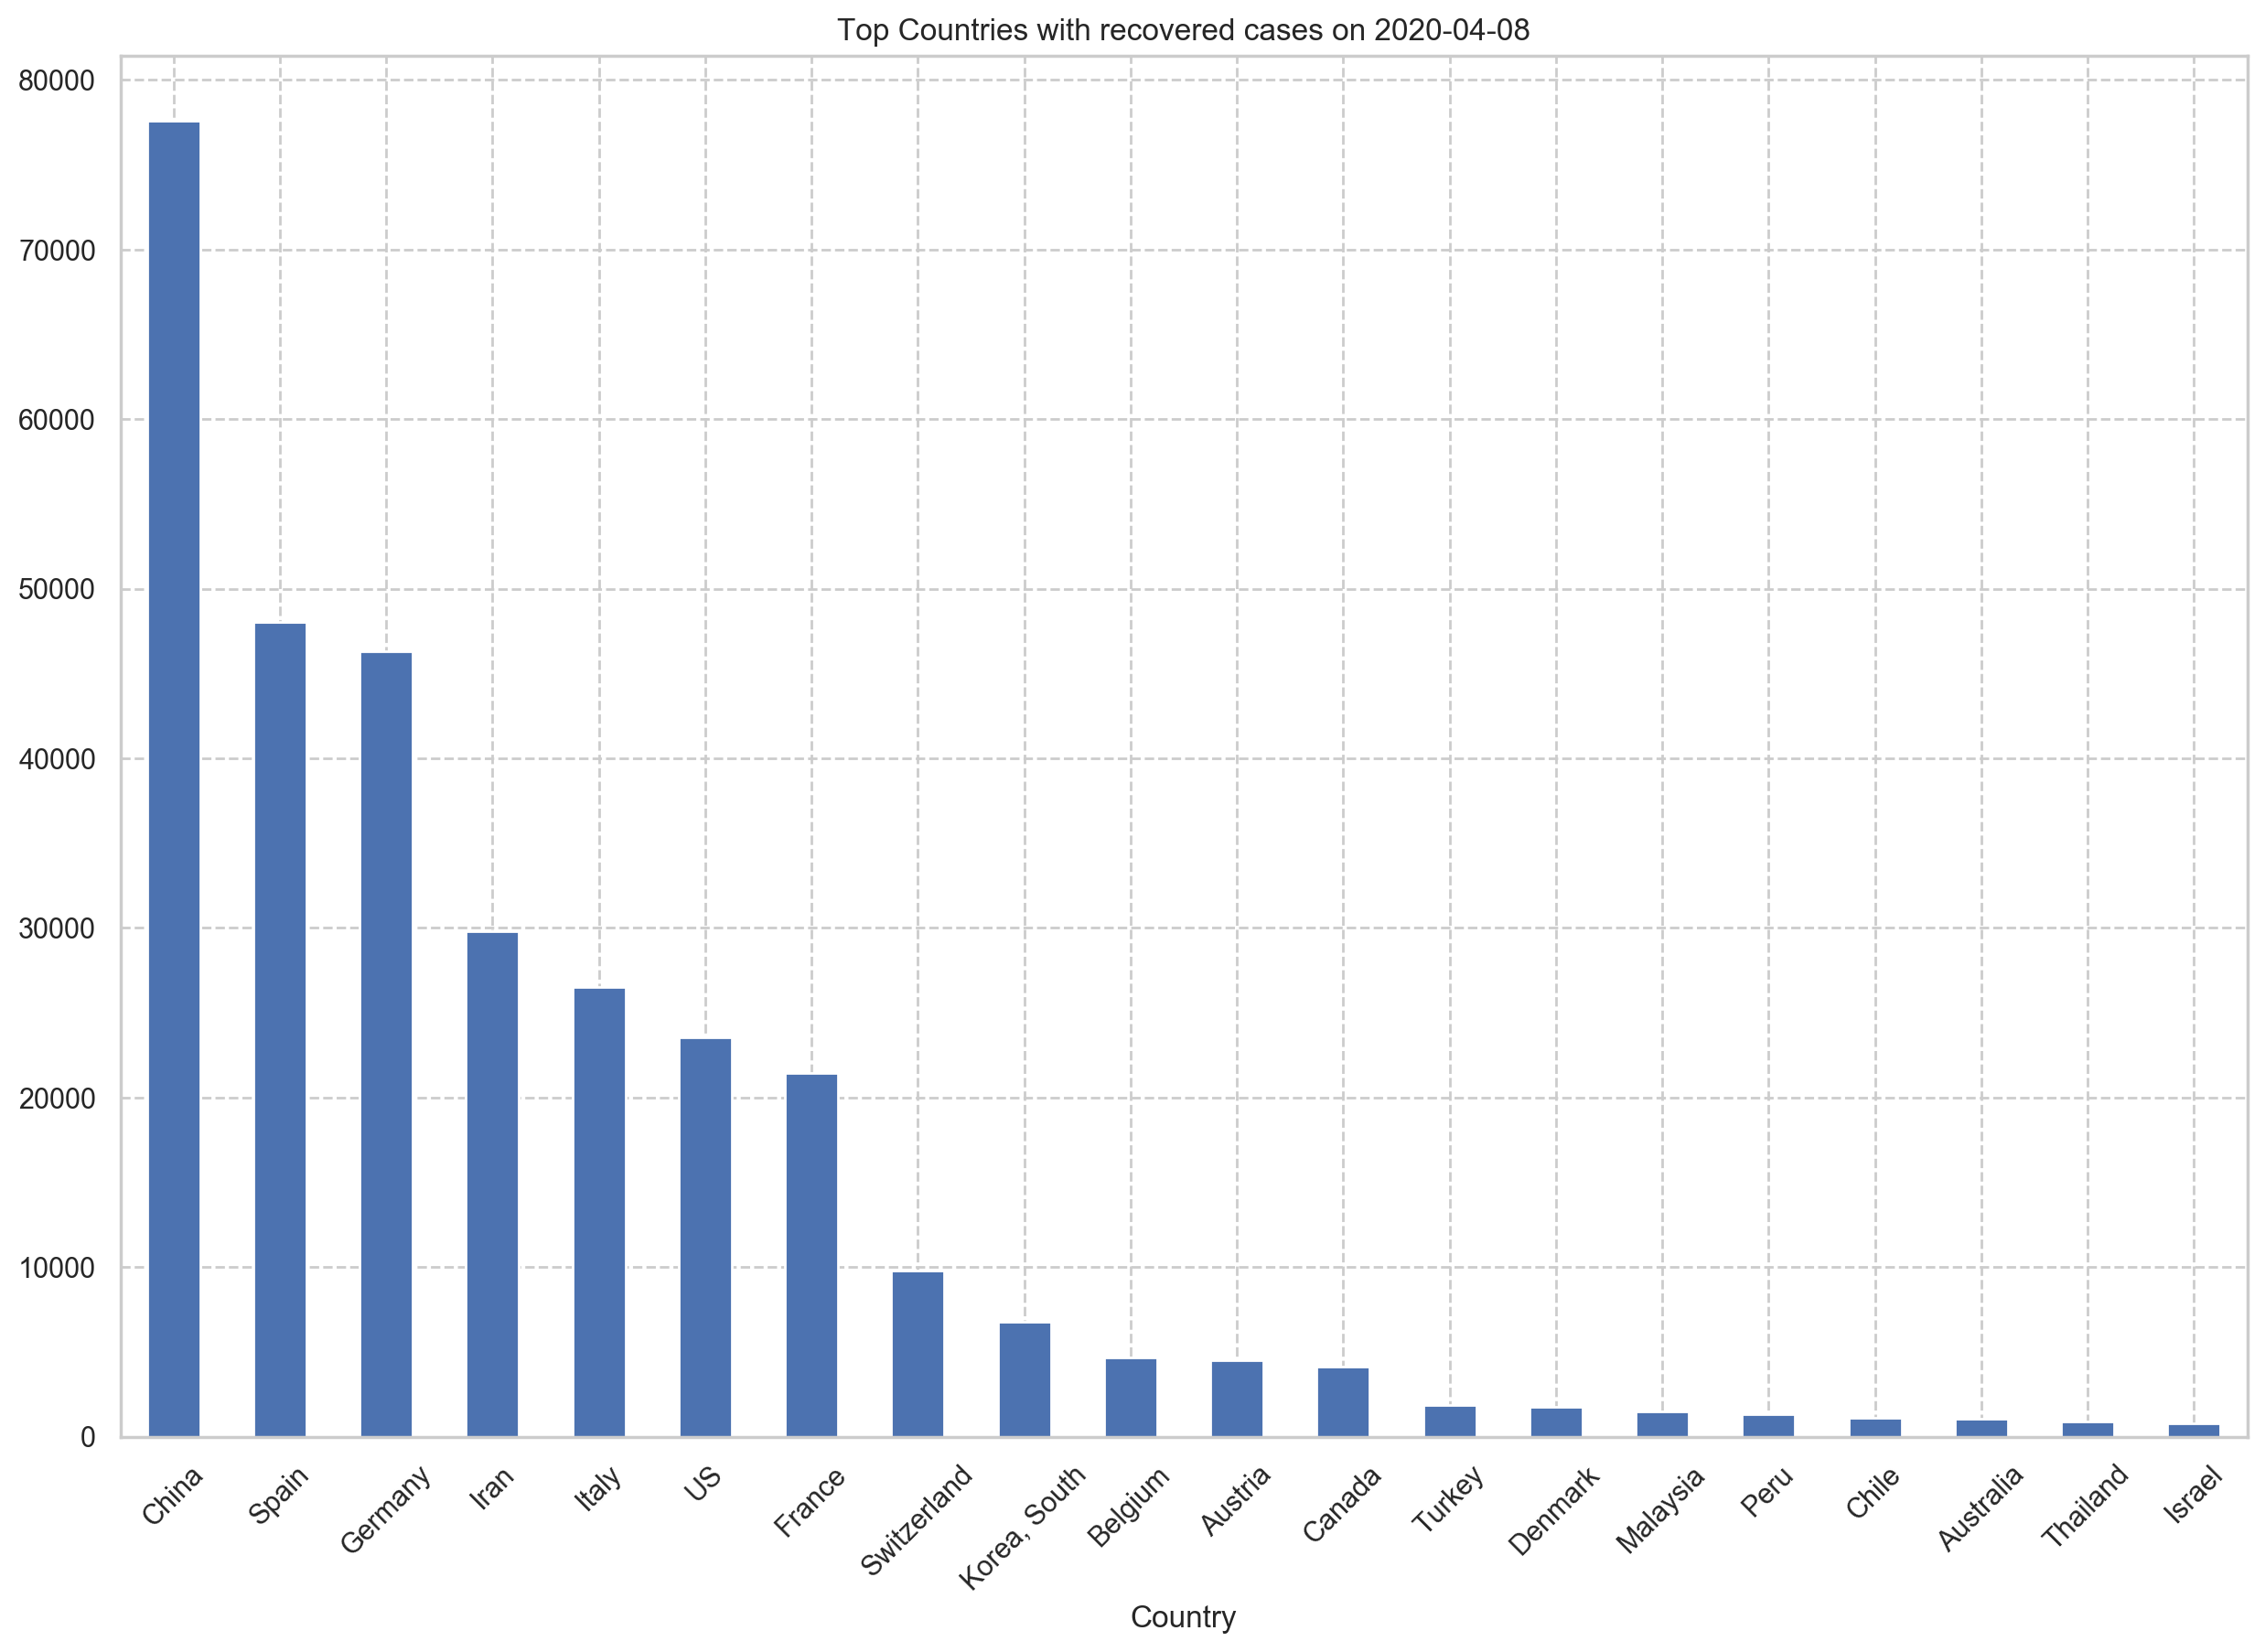

In [5]:
for i in range(3):
    plt.figure(dpi=200)
    _ = sets_grouped[i][yesterday].sort_values(ascending=False).head(20)
    _.plot.bar(title="Top Countries with {} on ".format(cases[i]) +  yesterday_date, figsize=(15,10), rot=45)
    plt.savefig('plots/top_{}.png'.format(cases[i]))
    plt.show()

## Mortality rate

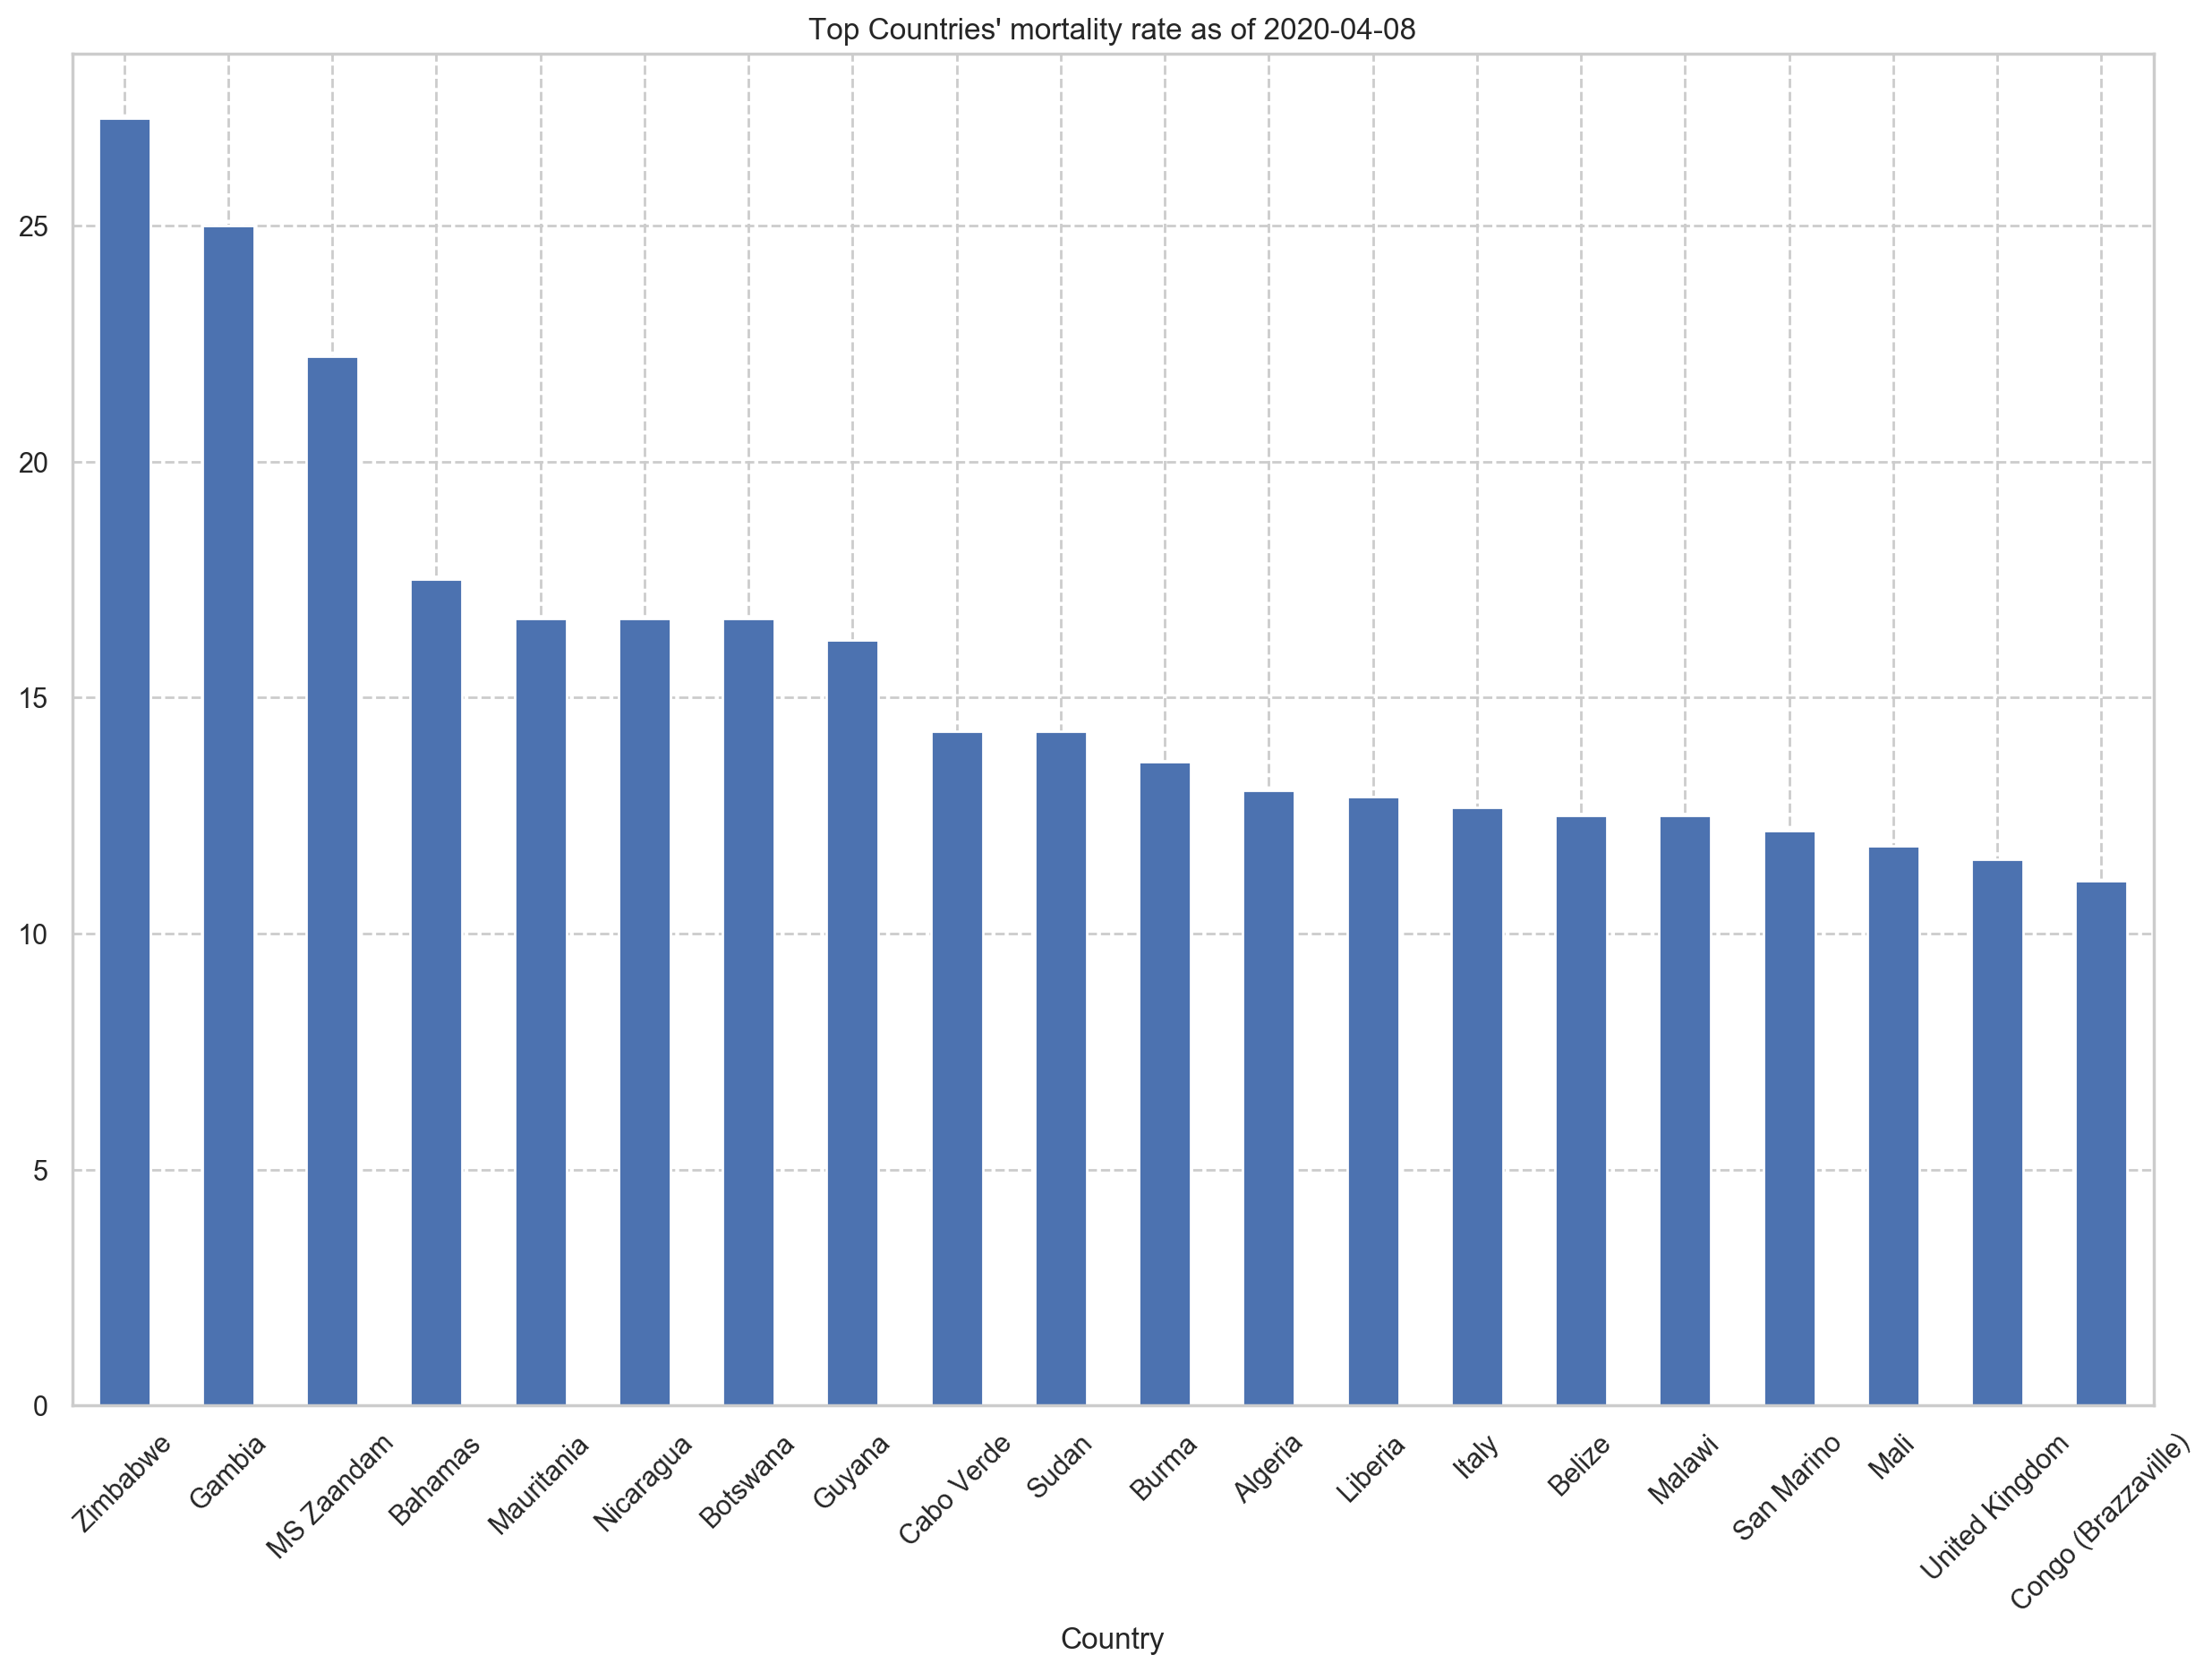

In [6]:
mortality_rate = sets_grouped[1] / sets_grouped[0] * 100
top_mortality = mortality_rate[yesterday].sort_values(ascending=False).head(20)
plt.figure(dpi=200)
top_mortality.plot.bar(title="Top Countries' mortality rate as of " +  yesterday_date, figsize=(15,10), rot=45)
plt.savefig('plots/top_mortality.png')
plt.show()

## World totals
---

In [7]:
for i in range(3):
    print('World total {}: {}'.format(cases[i], sets[i].sum()[yesterday]))
print('World total mortality rate: {:.2f}%'.format(sets[1].sum()[yesterday]/sets[0].sum()[yesterday] * 100))
print('World total recovery rate: {:.2f}%'.format(sets[2].sum()[yesterday]/sets[0].sum()[yesterday] * 100))

World total confirmed cases: 1511104
World total deaths: 88338
World total recovered cases: 328661
World total mortality rate: 5.85%
World total recovery rate: 21.75%


---
## Daily cases

Here we define the following parameters:

* ```n_top```: Number of top countries to be analyzed.
* ```roll```: Number of days over which we roll to make an averaged time series.
* ```conf```: Number of confirmed cases each country had when we started to count.
* ```death```: Number of deaths each country had when we started to count.

We then define two functions:

* ```dailyC()```: Performs operations on the passed DataFrame to obtain the daily recorded cases. Returns another DataFrame. Parameters:
    * ```df```: DataFrame to be pass.
    * ```n_cat```: Either ```conf```or ```death```.
    * ```n_top```.
* ```bokeh_plot()```: A [bokeh](boke.org) time series plot showing daily recorded cases. Returns the plot and saves it to a html file. Parameters:
    * ```dataF```: DataFrame to be pass.
    * ```cat```: Either 'confirmed', 'deaths' or 'recoveries', depending on the case.
    * ```n_cat```: Either ```conf```or ```death```.
    * ```n_top```.
    * ```tickers```: List of values to use for the ylog axis.

In [8]:
# How many top countries?
n_top = 10
# Rolling over how many days?
roll = 7
# Since how many confirmed cases?
conf = 100
# Since how many deaths?
death = 3

In [9]:
def dailyC(df, n_cat, n_top=n_top):
    
    ''' Daily cases '''
    # n_cat = number of cases since we start counting
    # n_top = number of top countries to show
    
    # Choose top countries
    top = df.sort_values(by=yesterday, ascending=False).iloc[:n_top, 2:].T
    top.head()

    # Compute daily cases
    daily= top.diff()

    top_countries = daily.columns
    dfs = []
    for i in top_countries:
        dfs.append(pd.DataFrame(daily[i][daily[i]>=n_cat].reset_index(drop=True))) 
    df = pd.concat(dfs, axis=1, join='outer').rolling(roll).mean()

    return df

def bokeh_plot(dataF, cat, n_cat, tickers, n_top=n_top):

    ''' Constumizations for the Bokeh plots '''
    # cat = {'confirmed', 'deaths', 'recoveries'}
    # n_cat = number of cases since we start counting
    # n_top = number of top countries to show
    # tickers = customized tickers for the logy axis
    
    from bokeh.io import output_notebook, output_file, show, reset_output
    from bokeh.plotting import figure, save
    from bokeh.models import ColumnDataSource, NumeralTickFormatter, HoverTool
    from bokeh.palettes import Category20

    #Specify the selection tools to be made available
    select_tools = ['box_zoom', 'pan', 'wheel_zoom', 'reset', 'crosshair', 'save']

    # Format the tooltip
    tooltips = [
        ('', '$name'),
        ('Days since', '$x{(0)}'), 
        ('{}'.format(cat), '$y{(0)}')
    ]

    p = figure(y_axis_type="log", plot_width=840, plot_height=600, 
               x_axis_label='Number of days since {} daily {} first recorded'.format(n_cat, cat), 
               y_axis_label='Daily records',
               title=
               'Daily {} ({}-day rolling average) by number of days ' \
               'since {} cases - top {} countries ' \
               '(as of {})'.format(cat, roll, n_cat, n_top, yesterday_date),
               toolbar_location='right',tools=select_tools)

    for i in range(n_top):
        p.line(dataF.index[6:], dataF.iloc[6:,i], line_width=2, color=Category20[20][i], alpha=0.8, 
               legend_label=dataF.columns[i], name=dataF.columns[i])
        p.circle(dataF.index[6:], dataF.iloc[6:,i], color=Category20[20][i], fill_color='white',
                 size=3, alpha=0.8, legend_label=dataF.columns[i], name=dataF.columns[i])

    p.yaxis.ticker = tickers

    p.legend.location = 'top_right'
    p.legend.click_policy='hide'

    p.add_tools(HoverTool(tooltips=tooltips))

    output_notebook()
    # output_file('Daily_{}.html'.format(cat), mode='inline')
    
    return show(p), save(p, 'plots/Daily_{}.html'.format(cat))

In [10]:
yticks_conf = [200,500,1000,2000,5000,10000,20000]
bokeh_plot(dailyC(sets_grouped[0], conf), 'confirmed', conf, yticks_conf)

yticks_death = [5,10,20,50,100,200,500,1000,2000]
bokeh_plot(dailyC(sets_grouped[1], death), 'deaths', death, yticks_death)

Loading BokehJS ...

Loading BokehJS ...

(None, '/Users/hramirez/GitHub/Covid19/plots/Daily_deaths.html')

## Geo-visualizations

We finally show two map scatter plots using the [plotly](https://plotly.com/python/scatter-plots-on-maps/) library.

In [11]:
fig = px.scatter_geo(world_confirmed,
                     lat="Lat", lon="Long", color=yesterday,
                     hover_name="Country", size=yesterday,
                     size_max=40, 
                     template='plotly', projection="natural earth",
                     title="COVID-19 worldwide confirmed cases")

fig.show()
pio.write_html(fig, file='plots/Geo_confirmed.html', auto_open=False)

In [12]:
fig = px.scatter_geo(world_deaths,
                     lat="Lat", lon="Long", color=yesterday,
                     hover_name="Country", size=yesterday,
                     size_max=40, 
                     template='plotly', projection="natural earth",
                     title="COVID-19 worldwide deaths")

fig.show()
pio.write_html(fig, file='plots/Geo_deaths.html', auto_open=False)